# 📝 Text super-resolution
* team name and members: Super-girls, **Agata Żywot 148258, Zuzanna Gawrysiak 148255**
* selected problem and dataset: Super-resolution, [TextZoom](https://paperswithcode.com/dataset/textzoom)

In [1]:
import cv2
import PIL
import numpy as np
from IPython.display import display
import sys
if '../' not in sys.path:
    sys.path.append('../')
import random
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.model_selection import train_test_split


import torch
from torch.utils.data import Dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
print("Using torch", torch.__version__)

from src.mdb_to_jpg import mdb_to_jpg
from src.utils import *
from src.data import *
from src.models.srresnet import _NetG, _NetD
from src.models.srresnet_train import sr_resnet_perform_training
from src.cfg import *

c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Using torch 1.13.0+cpu


In [2]:
torch.manual_seed(8)
random.seed(8)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    device = torch.device("cuda") 
    
else:
    device = torch.device("cpu")

print(f"Using torch { torch.__version__} on {device}")

Using torch 1.13.0+cpu on cpu


In [3]:
torch.cuda.empty_cache()

## Dataset

### Description
Number of images in each subset:
* train: 17367
* test:
    * easy: 1619
    * medium: 1411
    * hard: 1343

In [4]:
# TODO change for train1 at the end since it's > 10000
data_path = 'data/TextZoom/train2_img/'
lmdb_file = 'data/TextZoom/train2'
N = mdb_to_jpg(data_path, lmdb_file)

Number of samples: 2794


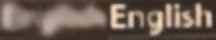

In [5]:
# DISPLAY EXEMPLARY IMAGES
x = 10
imgHR = cv2.imread(data_path+str(x)+'_img_HR.jpg', 1)
imgLR = cv2.imread(data_path+str(x)+'_img_LR.jpg', 1)
show_LR_HR_images(imgLR, imgHR)

In [6]:
# GET HR AND LR images
img_data = get_data_from_dir(data_path, [str(i) for i in range(1, N+1)])

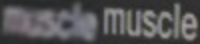

In [7]:
# GET HR AND LR images
data = get_data_from_dir(data_path, [str(i) for i in range(1, N+1)])
x = 1234
show_LR_HR_images(img_data[x][0], img_data[x][1])

### Data preprocessing

In [8]:
LR_images = list(map(lambda x: x[0].shape[:-1], img_data))
HR_images = list(map(lambda x: x[1].shape[:-1], img_data))

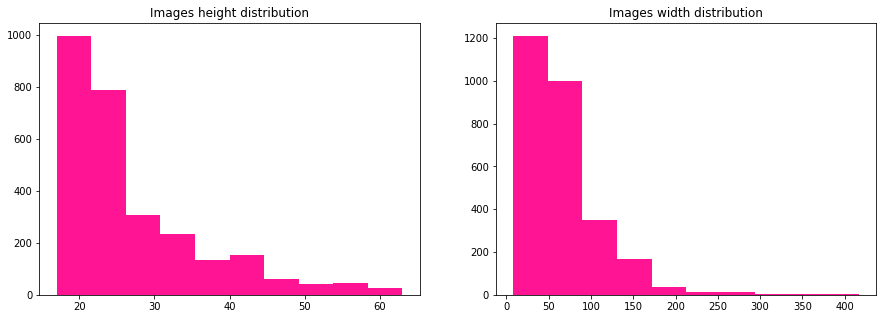

In [9]:
get_height_width_distribution(LR_images)

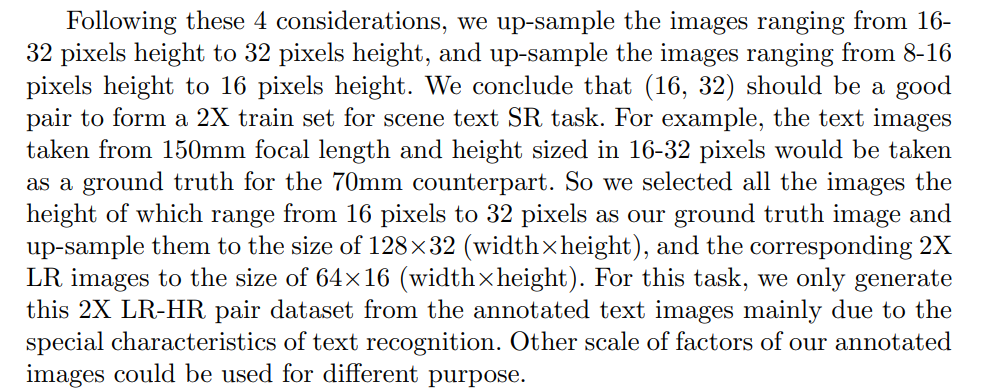<br>
For now I'll just discard the images which height is less than 8 (as they did in paper) and unify the size by padding (but this one should be discussed)

In [10]:
img_data = get_data_from_dir(data_path, [str(i) for i in range(1, N+1)], min_height=8)

In [11]:
# TODO -> replace src.data.SRDataset with the final one
class SRDataset(Dataset):
    def __init__(self, images, crop=True, normalize=True): 
        self.normalize = normalize
        self.crop = crop
        self.images = images

    def __len__(self):
        return len(self.images)

    def preprocess_image(self, image):
        lr = image[0]
        hr = image[1]
        if self.crop:
            lr = cv2.resize(lr, (64, 16))
            hr = cv2.resize(hr, (128, 32))
        if self.normalize:
            lr = lr / 255 # [0, 1]
            hr = hr/ 255 

        return torch.tensor(lr).swapaxes(1,2).swapaxes(0,1), torch.tensor(hr).swapaxes(1,2).swapaxes(0,1)

    def __getitem__(self, index):        
        image = self.images[index]         
        return self.preprocess_image(image)

In [12]:
img_data_processed = SRDataset(img_data)

torch.Size([3, 16, 64])

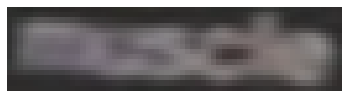

In [13]:
x = 1234
display_img_tensor(img_data_processed[x][0])
img_data_processed[x][0].shape

torch.Size([3, 32, 128])

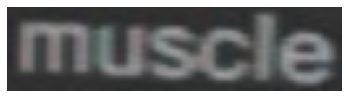

In [14]:
display_img_tensor(img_data_processed[x][1])
img_data_processed[x][1].shape

In [15]:
img_data_processed[x][0].shape

torch.Size([3, 16, 64])

In [16]:
generator = _NetG()
discriminator = _NetD()

example_batch = torch.stack([img_data_processed[x][0], img_data_processed[1235][0]], dim=0)
print(example_batch.shape)

torch.Size([2, 3, 16, 64])


torch.Size([2, 3, 16, 64])
torch.Size([2, 64, 16, 64])
torch.Size([2, 64, 16, 64])
torch.Size([2, 64, 16, 64])
torch.Size([2, 64, 16, 64])
torch.Size([2, 64, 32, 128])
torch.Size([2, 3, 32, 128])


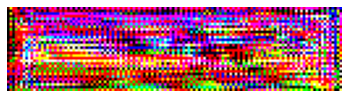

In [17]:
example_SR = generator.forward(example_batch.float())
display_img_tensor(example_SR.detach()[0])

torch.Size([2, 3, 16, 64])
torch.Size([2, 64, 16, 64])
torch.Size([2, 64, 16, 64])
torch.Size([2, 64, 16, 64])
torch.Size([2, 64, 16, 64])
torch.Size([2, 64, 32, 128])
torch.Size([2, 3, 32, 128])


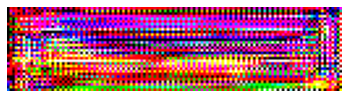

In [18]:
example_SR = generator.forward(example_batch.float())
display_img_tensor(example_SR.detach()[1])

In [19]:
dec = discriminator.forward(example_SR.float())
dec

torch.Size([2, 3, 32, 128])
torch.Size([2, 512, 2, 8])
torch.Size([2, 8192])
torch.Size([2, 1024])
torch.Size([2, 1024])
torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])


tensor([[0.4759],
        [0.4746]], grad_fn=<SigmoidBackward0>)

In [20]:
train_indices, test_indices = train_test_split(range(N), test_size=0.01)
len(train_indices), len(test_indices)

(2766, 28)

## Models

### SRResNet

In [21]:
train_set = torch.utils.data.Subset(img_data_processed, train_indices)
test_set = torch.utils.data.Subset(img_data_processed, test_indices)

In [22]:
target = torch.ones([8, 2], dtype=torch.float32)  # 8 classes, batch size = 2
print(target)
output = torch.full([8, 2], 1.5)  # A prediction (logit)
print(output)
pos_weight = torch.ones([2])  # All weights are equal to 1
print(pos_weight)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
print(criterion)
print(criterion(output, target))  # -log(sigmoid(1. 1))
# torch.sigmoid(torch.tensor([0, 1]))

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])
tensor([[1.5000, 1.5000],
        [1.5000, 1.5000],
        [1.5000, 1.5000],
        [1.5000, 1.5000],
        [1.5000, 1.5000],
        [1.5000, 1.5000],
        [1.5000, 1.5000],
        [1.5000, 1.5000]])
tensor([1., 1.])
BCEWithLogitsLoss()
tensor(0.2014)


In [23]:
cfg = read_config("cfg/models/srresnet.yaml")
cfg['epochs'] = 2
# cfg['batch_size'] = 16

# sr_resnet_perform_training(train_set=train_set, cfg=cfg, run_neptune=False)
sr_resnet_perform_training(train_set=test_set, cfg=cfg, run_neptune=False)

===> Runs with VGG model support (VGG loss applied)
===> Setting Optimizers
===> Training


Epoch 1:   0%|          | 0/2 [00:00<?, ?batch/s]

torch.Size([16, 3, 16, 64])
torch.Size([16, 64, 16, 64])
torch.Size([16, 64, 16, 64])
torch.Size([16, 64, 16, 64])
torch.Size([16, 64, 16, 64])
torch.Size([16, 64, 32, 128])
torch.Size([16, 3, 32, 128])
GENERATOR
torch.Size([16, 3, 32, 128])
torch.Size([16, 512, 2, 8])
torch.Size([16, 8192])
torch.Size([16, 1024])
torch.Size([16, 1024])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
sr_discriminated tensor([[0.4632],
        [0.4499],
        [0.4059],
        [0.4762],
        [0.4496],
        [0.4422],
        [0.3980],
        [0.4537],
        [0.4309],
        [0.5053],
        [0.4581],
        [0.4051],
        [0.4440],
        [0.4363],
        [0.4613],
        [0.4439]], grad_fn=<SigmoidBackward0>)
adversarial_loss 0.49519670009613037
torch.Size([16, 3, 32, 128])
torch.Size([16, 512, 2, 8])
torch.Size([16, 8192])
torch.Size([16, 1024])
torch.Size([16, 1024])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 3, 32, 128])
torch.Size([16,

Epoch 1:  50%|█████     | 1/2 [00:05<00:05,  5.34s/batch, adversarial_loss=1.43, content_loss_VGG=1.6]

torch.Size([12, 3, 16, 64])
torch.Size([12, 64, 16, 64])
torch.Size([12, 64, 16, 64])
torch.Size([12, 64, 16, 64])
torch.Size([12, 64, 16, 64])
torch.Size([12, 64, 32, 128])
torch.Size([12, 3, 32, 128])
GENERATOR
torch.Size([12, 3, 32, 128])
torch.Size([12, 512, 2, 8])
torch.Size([12, 8192])
torch.Size([12, 1024])
torch.Size([12, 1024])
torch.Size([12, 1])
torch.Size([12, 1])
torch.Size([12, 1])
sr_discriminated tensor([[0.1445],
        [0.0967],
        [0.1178],
        [0.0857],
        [0.1452],
        [0.0596],
        [0.1137],
        [0.1348],
        [0.1682],
        [0.1191],
        [0.1558],
        [0.1071]], grad_fn=<SigmoidBackward0>)
adversarial_loss 0.6347396373748779
torch.Size([12, 3, 32, 128])
torch.Size([12, 512, 2, 8])
torch.Size([12, 8192])
torch.Size([12, 1024])
torch.Size([12, 1024])
torch.Size([12, 1])
torch.Size([12, 1])
torch.Size([12, 1])
torch.Size([12, 3, 32, 128])
torch.Size([12, 512, 2, 8])
torch.Size([12, 8192])
torch.Size([12, 1024])
torch.Size([12

Epoch 2:   0%|          | 0/2 [00:00<?, ?batch/s]

torch.Size([16, 3, 16, 64])
torch.Size([16, 64, 16, 64])
torch.Size([16, 64, 16, 64])
torch.Size([16, 64, 16, 64])
torch.Size([16, 64, 16, 64])
torch.Size([16, 64, 32, 128])
torch.Size([16, 3, 32, 128])
GENERATOR
torch.Size([16, 3, 32, 128])
torch.Size([16, 512, 2, 8])
torch.Size([16, 8192])
torch.Size([16, 1024])
torch.Size([16, 1024])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
sr_discriminated tensor([[0.0206],
        [0.0382],
        [0.0221],
        [0.0260],
        [0.0225],
        [0.0195],
        [0.0374],
        [0.0224],
        [0.0407],
        [0.0269],
        [0.0171],
        [0.0417],
        [0.0347],
        [0.0195],
        [0.0295],
        [0.0279]], grad_fn=<SigmoidBackward0>)
adversarial_loss 0.6792935729026794
torch.Size([16, 3, 32, 128])
torch.Size([16, 512, 2, 8])
torch.Size([16, 8192])
torch.Size([16, 1024])
torch.Size([16, 1024])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 3, 32, 128])
torch.Size([16, 

Epoch 2:  50%|█████     | 1/2 [00:04<00:04,  4.81s/batch, adversarial_loss=1.12, content_loss_VGG=0.684]

torch.Size([12, 3, 16, 64])
torch.Size([12, 64, 16, 64])
torch.Size([12, 64, 16, 64])
torch.Size([12, 64, 16, 64])
torch.Size([12, 64, 16, 64])
torch.Size([12, 64, 32, 128])
torch.Size([12, 3, 32, 128])
GENERATOR
torch.Size([12, 3, 32, 128])
torch.Size([12, 512, 2, 8])
torch.Size([12, 8192])
torch.Size([12, 1024])
torch.Size([12, 1024])
torch.Size([12, 1])
torch.Size([12, 1])
torch.Size([12, 1])
sr_discriminated tensor([[0.0311],
        [0.0233],
        [0.0597],
        [0.0232],
        [0.0480],
        [0.0119],
        [0.0415],
        [0.0345],
        [0.0449],
        [0.0286],
        [0.0376],
        [0.0286]], grad_fn=<SigmoidBackward0>)
adversarial_loss 0.6761116981506348
torch.Size([12, 3, 32, 128])
torch.Size([12, 512, 2, 8])
torch.Size([12, 8192])
torch.Size([12, 1024])
torch.Size([12, 1024])
torch.Size([12, 1])
torch.Size([12, 1])
torch.Size([12, 1])
torch.Size([12, 3, 32, 128])
torch.Size([12, 512, 2, 8])
torch.Size([12, 8192])
torch.Size([12, 1024])
torch.Size([12

Epoch 2: 100%|██████████| 2/2 [00:08<00:00,  4.27s/batch, adversarial_loss=1.05, content_loss_VGG=0.541]


### Exemplary predictions

In [ ]:
# TODO show sample predictions

In [93]:
checkpoint = torch.load('checkpoints/weights.pth', map_location=torch.device('cpu'))
new_model = checkpoint['model']

# load_model(new_model, 'checkpoints/weights.pth')
# new_model.to(device)
# new_model

torch.Size([2, 3, 16, 64])
torch.Size([2, 64, 16, 64])
torch.Size([2, 64, 16, 64])
torch.Size([2, 64, 16, 64])
torch.Size([2, 64, 16, 64])
torch.Size([2, 64, 32, 128])
torch.Size([2, 3, 32, 128])


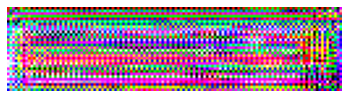

In [94]:
new_model.eval()
LR_res = new_model.forward(example_batch.float())
display_img_tensor(LR_res.detach()[0])

tensor(-11.2065)
tensor(10.6835)
torch.Size([3, 32, 128])


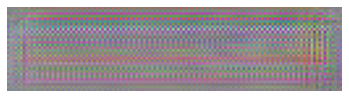

In [95]:
LR_res_img = LR_res[0].detach()
# print(LR_res_img)
min_value = LR_res_img.min()
print(min_value)
max_value = LR_res_img.max()
print(max_value)
normalized_tensor = (LR_res_img - min_value) / (max_value - min_value)
print(normalized_tensor.shape)
display_img_tensor(normalized_tensor)
# normalized_tensor

### Text Gestalt

The next tested model is based on the paper ["Text Gestalt: Stroke-Aware Scene Text Image Super-Resolution"](https://arxiv.org/pdf/2112.08171v1.pdf). We used code available at [GitHub](https://github.com/FudanVI/FudanOCR/tree/main/text-gestalt) and trained the net architecture from scratch.

The model is inspired by Gestalt Psychology, which states that humans can construct the complete appearance of object with the guidance of local details. Therefore English characters can be decomposed as follows:

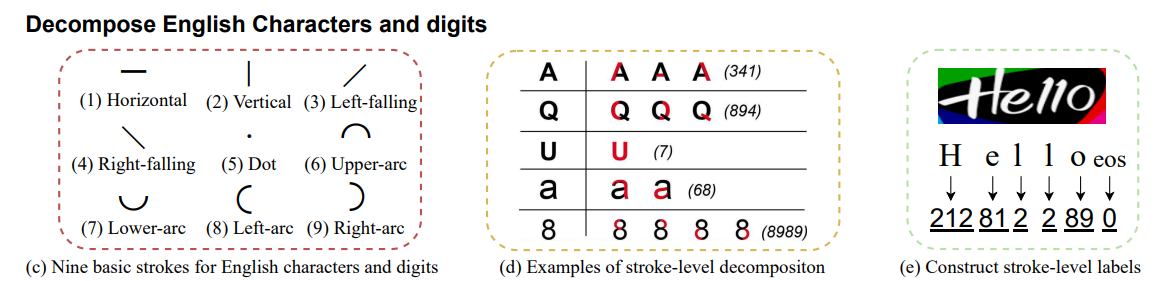
#### Overall architecture
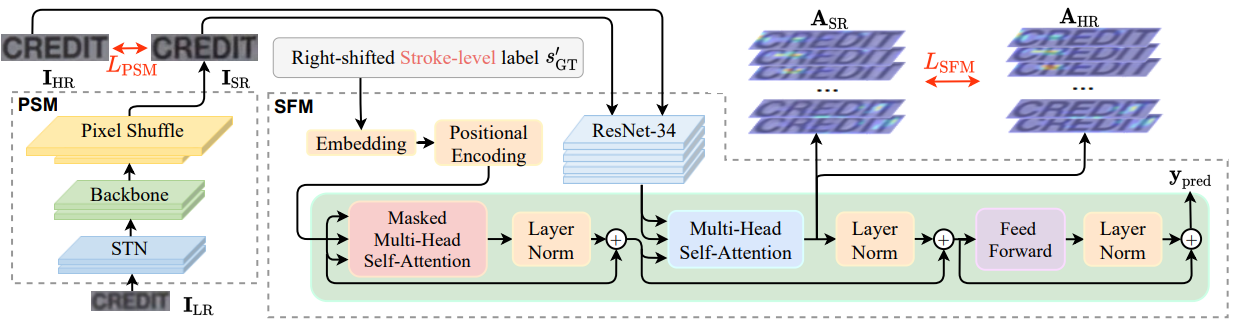

It is worth noticining that the model uses [Multi-Head Self-Attention](https://arxiv.org/pdf/1706.03762v5.pdf) to generate stroke-level maps.
#### Model analysis
* size: 10.3MB
* number of parameters: 2671020
* used metrics: 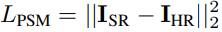
#### Learning curves

#### Sample images